# Exploring Dandiset 001433: Breathing Rhythm and Place Dataset

*This notebook was generated with the assistance of AI. Please exercise caution when interpreting the code or derived results, and verify outputs for your own analyses.*

## Overview

This notebook introduces the Dandiset [001433: Breathing rhythm and place dataset](https://dandiarchive.org/dandiset/001433/0.250507.2356), which contains behavioral and electrophysiological data from recordings of sniffing, video, and olfactory bulb (OB) electrophysiology in freely-behaving mice. Mice in this dataset were not subjected to stimulus, reward, or explicit task.

The package includes:
- Extracellular electrophysiology (multi-electrode LFP recordings) from the olfactory bulb
- Raw sniff thermistor voltage recordings
- Annotated inhalation and exhalation event times
- Metadata and electrode information

All data are stored in Neurodata Without Borders (NWB) format and can be accessed using the DANDI API, streamed directly without a full download.

## What does this notebook cover?
- How to access and browse the Dandiset using the DANDI API
- How to stream and load NWB files from the archive
- Overview of key data structures within the NWB files
- Simple visualizations of LFP and sniffing data
- Guidance on accessing behavioral event times and electrode metadata

## Required Packages
To execute the notebook, please ensure the following packages are available (assumed to be already installed):
- `pynwb`
- `h5py`
- `remfile`
- `dandi`
- `matplotlib`
- `numpy`
- `pandas`

---

Let's get started!

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from dandi.dandiapi import DandiAPIClient
import remfile
import h5py
import pynwb

## Accessing Dandiset 001433 via the DANDI API

We'll begin by querying the Dandiset and displaying available NWB assets.

In [2]:
# Connect to DANDI and get the dandiset object (version 0.250507.2356)
dandiset_id = "001433"
dandiset_version = "0.250507.2356"

client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List up to 5 assets in the Dandiset for demonstration
print("Listing sample assets in Dandiset 001433:")
for asset in dandiset.get_assets():
    print(asset.path)
    # Limit printout for demonstration
    if "sub-4127" in asset.path:
        break

Listing sample assets in Dandiset 001433:
sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb
sub-4122/sub-4122_ses-20250507T152930_ecephys.nwb
sub-4122/sub-4122_ses-20250507T152933_ecephys.nwb
sub-4127/sub-4127_ses-20250507T152941_ecephys.nwb


## Loading and Streaming an Example NWB File

Instead of downloading files, we will stream data directly from a remote NWB file. Here we select one session from subject `sub-4122`.

In [3]:
# Choose a specific NWB asset to work with
nwb_path = "sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb"

# Fetch the remote download URL
asset = next(dandiset.get_assets_by_glob(nwb_path))
url = asset.download_url

# Open a remote file handle for streaming access
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
# Open with pynwb for further inspection
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

print(f"Session description: {nwb.session_description}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Experimenter: {nwb.experimenter}")

Session description: LFP and sniff recording
Session start time: 2025-05-07 15:29:27.359523-07:00
Experimenter: ('Rafilson, Sidney',)


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## What's Inside the NWB File?

Let's quickly summarize the types of data and metadata in the file:
- Electrophysiological LFP recordings from 16 electrodes (`acquisition['LFP']`)
- Sniffing (thermistor voltage) time series (`acquisition['SniffSignal']`)
- Annotated inhalation/exhalation times (`processing['behavior']`)
- Electrode location and group metadata
- Subject and experiment information

We'll next explore the contents interactively.

In [4]:
# List available acquisitions and processing modules
print("Acquisition keys:", list(nwb.acquisition.keys()))
print("Processing modules:", list(nwb.processing.keys()))

Acquisition keys: ['LFP', 'SniffSignal']
Processing modules: ['behavior']


## Electrode Metadata Overview

Electrode location, filtering, and group information are stored in the `electrodes` table.
Let's display this information as a DataFrame.

In [5]:
# Convert electrodes table to a pandas DataFrame
electrodes_df = nwb.electrodes.to_dataframe()
electrodes_df.head()

,location,group,group_name,filtering
id,,,,
0,olfactory bulb,LFPGroup pynwb.ecephys.ElectrodeGroup at 0x133...,LFPGroup,none
1,olfactory bulb,LFPGroup pynwb.ecephys.ElectrodeGroup at 0x133...,LFPGroup,none
2,olfactory bulb,LFPGroup pynwb.ecephys.ElectrodeGroup at 0x133...,LFPGroup,none
3,olfactory bulb,LFPGroup pynwb.ecephys.ElectrodeGroup at 0x133...,LFPGroup,none
4,olfactory bulb,LFPGroup pynwb.ecephys.ElectrodeGroup at 0x133...,LFPGroup,none


## Visualizing LFP Data

The LFP recordings are sampled at 1000 Hz from 16 electrodes. Each column in the LFP data array represents an electrode.

Let's plot a brief segment of the LFP signals from a subset of electrodes.

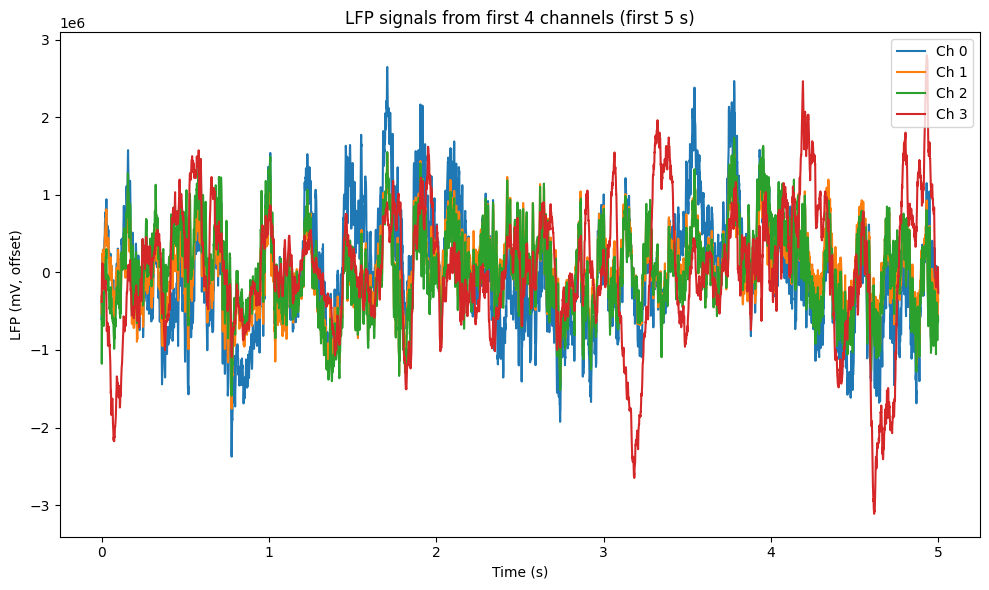

In [6]:
# Access LFP ElectricalSeries object and its data
LFP = nwb.acquisition['LFP']
lfp_rate = LFP.rate                  # Hz
lfp_data = LFP.data                  # shape (time, channels)
n_channels = lfp_data.shape[1]

# Select a short segment (first 5 seconds)
segment_sec = 5
segment_len = int(segment_sec * lfp_rate)
lfp_segment = lfp_data[:segment_len, :4]  # First 4 channels for clarity

time = np.arange(segment_len) / lfp_rate

plt.figure(figsize=(10, 6))
for i in range(lfp_segment.shape[1]):
    plt.plot(time, lfp_segment[:, i]*1e3 + i*2, label=f'Ch {i}')  # Offset for clarity, scale to mV
plt.xlabel('Time (s)')
plt.ylabel('LFP (mV, offset)')
plt.title('LFP signals from first 4 channels (first 5 s)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Visualizing Sniff Signal

The sniff signal records the raw thermistor voltage representing breathing dynamics.
Let's plot the same 5-second segment.

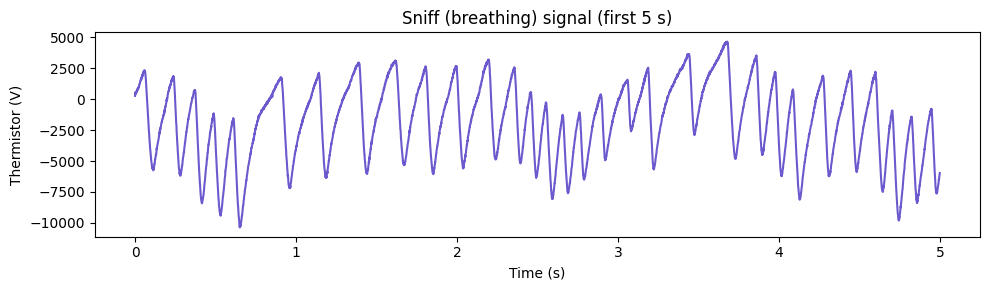

In [7]:
# Access sniff signal data
SniffSignal = nwb.acquisition['SniffSignal']
sniff_data = SniffSignal.data[:segment_len]
sniff_time = np.arange(segment_len) / SniffSignal.rate

plt.figure(figsize=(10, 3))
plt.plot(sniff_time, sniff_data, color='slateblue')
plt.xlabel('Time (s)')
plt.ylabel('Thermistor (V)')
plt.title('Sniff (breathing) signal (first 5 s)')
plt.tight_layout()
plt.show()

## Annotated Inhalation and Exhalation Events

The file provides timestamps for inhalation and exhalation events (as detected from the sniff signal). Let's visualize inhalation and exhalation times superimposed on the sniff trace.

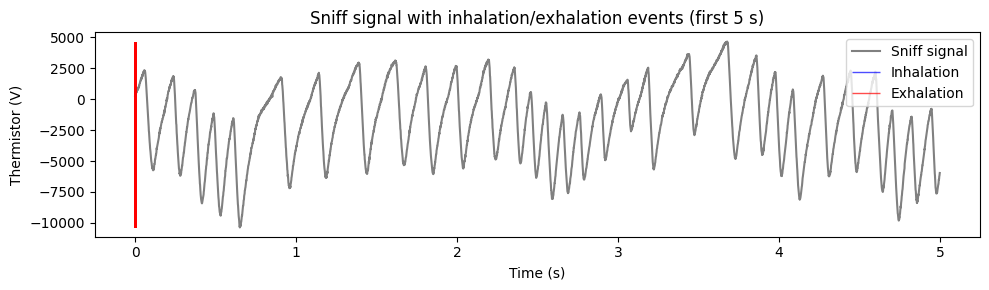

In [8]:
# Access inhalation and exhalation event times
behavior = nwb.processing['behavior']
inhale = behavior.data_interfaces['inhalation_time']
exhale = behavior.data_interfaces['exhalation_time']

# Get event times within our plotted segment
inhale_ts = inhale.timestamps[:]
exhale_ts = exhale.timestamps[:]
# Filter to first 5 s
inhale_ts_plot = inhale_ts[(inhale_ts >= 0) & (inhale_ts < segment_sec)]
exhale_ts_plot = exhale_ts[(exhale_ts >= 0) & (exhale_ts < segment_sec)]

plt.figure(figsize=(10, 3))
plt.plot(sniff_time, sniff_data, color='gray', label='Sniff signal')
plt.vlines(inhale_ts_plot, ymin=min(sniff_data), ymax=max(sniff_data), color='blue', alpha=0.7, linewidth=1, label='Inhalation')
plt.vlines(exhale_ts_plot, ymin=min(sniff_data), ymax=max(sniff_data), color='red', alpha=0.7, linewidth=1, label='Exhalation')
plt.xlabel('Time (s)')
plt.ylabel('Thermistor (V)')
plt.title('Sniff signal with inhalation/exhalation events (first 5 s)')
plt.legend()
plt.tight_layout()
plt.show()

## Accessing Subject and Experimental Metadata

Each NWB file contains descriptive metadata. Let's show subject and experiment details.

In [9]:
subject = nwb.subject
print(f"Subject ID: {subject.subject_id}")
print(f"Species: {subject.species}")
print(f"Sex: {subject.sex}")
print(f"Age: {subject.age} (reference: {subject.age__reference})")
print(f"Subject Description: {subject.description}")

print(f"\nExperiment description: {nwb.experiment_description}")
print(f"Lab: {nwb.lab}")
print(f"Institution: {nwb.institution}")

Subject ID: 4122
Species: Mus musculus
Sex: M
Age: P90D (reference: birth)
Subject Description: Lab mouse used for sniffing + LFP experiment

Experiment description: LFP and sniff behavior recording
Lab: Smear lab
Institution: University of Oregon


## Summary and Next Steps

- This Dandiset is a rich resource for olfactory bulb electrophysiology and breathing rhythm in unrestrained mice.
- You can stream large NWB files directly with remfile/h5py/pynwb, and access both raw and processed signals.
- Use metadata tables to relate signal channels to brain regions, groups, and filtering patterns.
- Many other sessions and subjects are available in this Dandiset; adapt these examples to explore further.

**Potential reanalysis directions:**
- Relate OB LFP oscillations to the phase of the sniff cycle
- Compute event-triggered averages of LFP signals
- Compare breathing dynamics across different sessions or animals

---

*Refer to the [Dandi Archive page](https://dandiarchive.org/dandiset/001433/0.250507.2356) or consult the NWB standard documentation for more advanced data access and manipulation methods.*